In [1]:
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models

In [2]:
def resize_images_in_directory(root_folder, target_width, target_height):
    count_images_resize = 0
    target_size = (target_width, target_height)
    for foldername, subfolders, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.endswith(".jpg"):
                image_path = os.path.join(foldername, filename)
                image = cv2.imread(image_path)
                resized_image = cv2.resize(image, target_size)
                cv2.imwrite(image_path, resized_image)
                count_images_resize += 1

    print(f"Resizing {count_images_resize} images to {target_width}x{target_height}")

In [3]:
target_width = 180
target_height = 180
resize_images_in_directory(".\\img_cls", target_width, target_height)

Resizing 36781 images to 180x180


In [4]:
def removeImagesCorrupted(root_folder):
    for foldername, subfolders, filenames in os.walk(root_folder):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            image_object = open(file_path, "rb")
            # Read the first 10 bytes to check for "JFIF" in the header
            header_data = image_object.read(10)
            is_jfif = tf.compat.as_bytes("JFIF") in header_data
            if not is_jfif:
                # Delete the corrupted image
                os.remove(file_path)
                print(f"Removed {file_path} (Corrupted image)")

In [5]:
removeImagesCorrupted(".\\img_cls")

In [6]:
def create_image_datasets(data_directory, validation_split, seed):
    image_data, val_data = tf.keras.utils.image_dataset_from_directory(
        data_directory,
        image_size=(target_width, target_height),
        validation_split=validation_split,
        subset="both",
        seed=seed
    )
    
    return image_data, val_data

In [7]:
validation_split = 0.2 # 80% for training, 20% for validation
seed = 123 # Random seed
train_ds, val_ds = create_image_datasets(".\\img_cls", validation_split, seed)

Found 36781 files belonging to 80 classes.
Using 29425 files for training.
Using 7356 files for validation.


In [8]:
#for data, labels in train_ds:
#   print(data.shape)  
#   print(data.dtype)  # float32
#   print(labels.shape) 
#   print(labels.dtype)  # int32#

In [9]:
# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
])

train_ds_augmentation = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Combine the original training dataset and the augmented training dataset
combined_train_ds = train_ds.concatenate(train_ds_augmentation)

In [10]:
print(f'len of train_ds = {len(train_ds)}')
print(f'len of val_ds = {len(val_ds)}')
print(f'len of train_ds_augmentation = {len(train_ds_augmentation)}')
print(f'len of combined_train_ds = {len(combined_train_ds)}')

len of train_ds = 920
len of val_ds = 230
len of train_ds_augmentation = 920
len of combined_train_ds = 1840


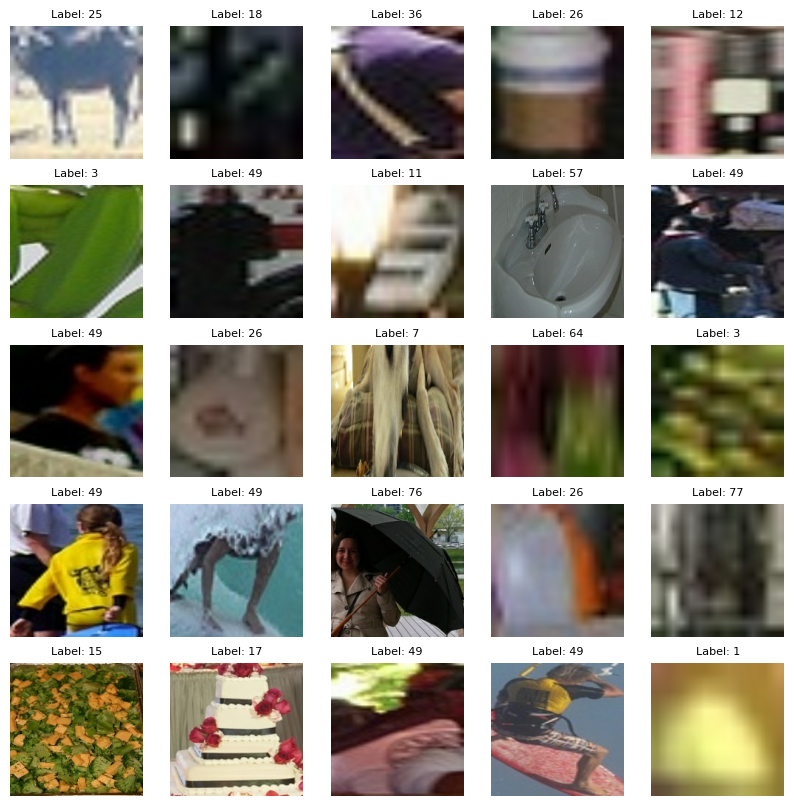

In [11]:
import matplotlib.pyplot as plt

# Use train_ds because training using combined_train_ds take so much time.
# The accuracy when use combined_train_ds is ~0.30
#iterator = iter(combined_train_ds)
iterator = iter(train_ds)

# Number of images to display (row * column)
num_row_to_display = 5
num_columns_to_display = 5
num_images_to_display = num_row_to_display * num_columns_to_display
inch_for_each_image = 2
# Get and display the images
plt.figure(figsize=(num_row_to_display * inch_for_each_image, num_columns_to_display * inch_for_each_image)) # 10 inch x 10 inch
for idx_image in range(num_images_to_display):
    image, label = next(iterator)
    plt.subplot(num_row_to_display, num_columns_to_display, idx_image + 1)
    plt.imshow(image[0].numpy().astype("uint8"))  # Assuming images are in the first dimension
    plt.title(f"Label: {label[0].numpy()}", fontsize=8)
    plt.axis("off")

plt.show()

In [12]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1.0 / 255)(inputs)

    # Layer 1
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 2
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 3
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten
    x = layers.Flatten()(x)

    # Layer 4
    x = layers.Dense(units=128, activation='relu')(x)

    # Dropout
    x = layers.Dropout(rate=0.5)(x)

    # Output Layer
    outputs = layers.Dense(units=num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

In [13]:
# Define the input shape and number of classes
input_shape = (180, 180, 3)
num_classes = 80

In [14]:
# Create the model
model = make_model(input_shape, num_classes)

In [15]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [16]:
# Train the model
##history = model.fit(combined_train_ds, epochs=25, validation_data=val_ds)
history = model.fit(x=train_ds, epochs=25, validation_data=val_ds)

Epoch 1/25
920/920 [==============================] - 460s 499ms/step - loss: 3.4592 - accuracy: 0.2948 - val_loss: 3.1071 - val_accuracy: 0.3089
Epoch 2/25
920/920 [==============================] - 453s 493ms/step - loss: 3.1573 - accuracy: 0.3127 - val_loss: 3.0111 - val_accuracy: 0.3144
Epoch 3/25
920/920 [==============================] - 440s 478ms/step - loss: 3.0129 - accuracy: 0.3231 - val_loss: 2.8956 - val_accuracy: 0.3316
Epoch 4/25
920/920 [==============================] - 443s 481ms/step - loss: 2.9030 - accuracy: 0.3336 - val_loss: 2.9007 - val_accuracy: 0.3318
Epoch 5/25
920/920 [==============================] - 439s 477ms/step - loss: 2.7957 - accuracy: 0.3440 - val_loss: 2.9120 - val_accuracy: 0.3348
Epoch 6/25
920/920 [==============================] - 437s 475ms/step - loss: 2.6862 - accuracy: 0.3547 - val_loss: 2.9341 - val_accuracy: 0.3441
Epoch 7/25
920/920 [==============================] - 434s 471ms/step - loss: 3.4963 - accuracy: 0.3113 - val_loss: 3.6126 -

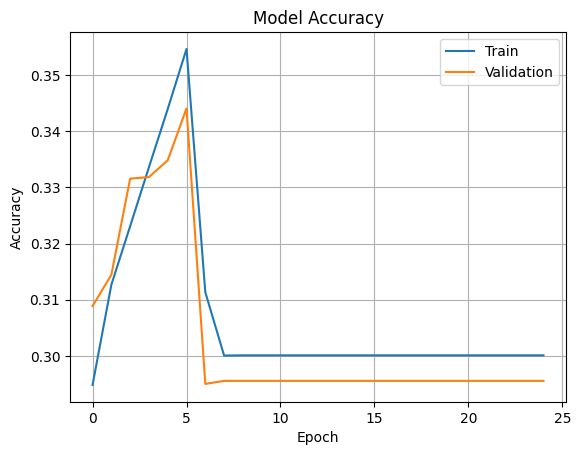

In [17]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(accuracy, label='Train')
plt.plot(val_accuracy, label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()